In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from imblearn.combine import SMOTEENN
from sklearn.inspection import permutation_importance

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive/')
%cd 'drive/Shareddrives/CSCI 461/processed'
#%ls processed/*


Mounted at /content/drive/
/content/drive/Shareddrives/CSCI 461/processed


# DATA MANIPULATION

In [ ]:
# Importing the data

data = pd.read_csv("combined_ohe_17.csv")
#data.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
#print(data.head())

In [ ]:
edu_matrix = data[["highedcert_associate degree","highedcert_bachelor degree","highedcert_high school or ged",
                  "highedcert_higher degree","highedcert_none of the above","highedcert_vocational certificate",
                  "highedcert_vocational license"]]
data["edu_categorical"] = edu_matrix.idxmax(axis=1)

In [ ]:
# making education binary

educationBinary = \
{   
    "highedcert_associate degree": 1,
    "highedcert_bachelor degree": 1,
    "highedcert_high school or ged": 1,
    "highedcert_higher degree": 1,
    "highedcert_none of the above":0,
    "highedcert_vocational certificate": 1,
    "highedcert_vocational license": 1
}
data['edu_binary'] = data["edu_categorical"].map(educationBinary) 

In [ ]:
# dropping overlap variables (and other outcome features, recnumbr)
# data.drop(columns=["recnumbr", "highedcert_associate degree","highedcert_bachelor degree","highedcert_high school or ged",
#                   "highedcert_higher degree","highedcert_none of the above","highedcert_vocational certificate",
#                   "highedcert_vocational license","edu_categorical", 'homeless_no','homeless_yes','subabuse_no',
#                    'subabuse_yes', 'incarc_no', 'incarc_yes', 'edu_categorical'], axis=1, inplace=True)
#subabuse
data.drop(columns=["recnumbr", "highedcert_associate degree","highedcert_bachelor degree","highedcert_high school or ged",
                  "highedcert_higher degree","highedcert_none of the above","highedcert_vocational certificate",
                  "highedcert_vocational license","edu_categorical", 'currpte_yes', 'currpte_no','currfte_yes', 
                   'currfte_no', 'edu_binary','homeless_no','homeless_yes', 'subabuse_no', 'incarc_no', 'incarc_yes', 'edu_categorical'], axis=1, inplace=True)
#data.nunique()

In [ ]:
# drop services (OPTIONAL)
data.drop(columns=['specedsv_No',
 'specedsv_Yes',
 'ilnasv_No',
 'ilnasv_Yes',
 'acsuppsv_No',
 'acsuppsv_Yes',
 'psedsuppsv_No',
 'psedsuppsv_Yes',
 'careersv_No',
 'careersv_Yes',
 'emplytrsv_No',
 'emplytrsv_Yes',
 'budgetsv_No',
 'budgetsv_Yes',
 'housedsv_No',
 'housedsv_Yes',
 'hlthedsv_No',
 'hlthedsv_Yes',
 'famsuppsv_No',
 'famsuppsv_Yes',
 'mentorsv_No',
 'mentorsv_Yes',
 'silsv_No',
 'silsv_Yes',
 'rmbrdfasv_No',
 'rmbrdfasv_Yes',
 'educfinasv_No',
 'educfinasv_Yes',
 'othrfinasv_No',
 'othrfinasv_Yes'], axis=1, inplace=True)

In [ ]:
# filtering for age 19+ and balancing the class
#data = data[data['age']>18].sort_values('age', ascending = False).sort_values('edu_binary').iloc[:1084*2,:]

target='subabuse_yes'

#subabuse
#data = data[data['age']>18].sort_values('age', ascending = False).sort_values(target)

#filter 17

# data = data[data['age']==17]
data.drop(columns=["age"], inplace=True)

## SETTING UP MODELS

In [ ]:
for i in ['amiakn','asian', 'blkafram', 'hawaiipi', 'white','raceunkn', 'hisorgin']:
  print(i)
  print(data[data[i+'_yes']==1].shape)
  print(data[data[i+'_yes']==1].subabuse_yes.value_counts()/len(data[data[i+'_yes']==1]))

amiakn
(1725, 112)
0    0.669565
1    0.330435
Name: subabuse_yes, dtype: float64
asian
(654, 112)
0    0.802752
1    0.197248
Name: subabuse_yes, dtype: float64
blkafram
(15630, 112)
0    0.81126
1    0.18874
Name: subabuse_yes, dtype: float64
hawaiipi
(294, 112)
0    0.751701
1    0.248299
Name: subabuse_yes, dtype: float64
white
(29487, 112)
0    0.740157
1    0.259843
Name: subabuse_yes, dtype: float64
raceunkn
(1297, 112)
0    0.784888
1    0.215112
Name: subabuse_yes, dtype: float64
hisorgin
(8349, 112)
0    0.765601
1    0.234399
Name: subabuse_yes, dtype: float64


In [ ]:
k=5
y = data.loc[:,target]
X = data.loc[:,data.columns != target]
X=X.reset_index(drop=True)
smote_enn = SMOTEENN(random_state=0)
X, y = smote_enn.fit_resample(X, y)

In [ ]:
data.subabuse_yes.value_counts() / len(data)

0    0.762521
1    0.237479
Name: subabuse_yes, dtype: float64

In [ ]:
y.value_counts() / len(y)

1    0.627834
0    0.372166
Name: subabuse_yes, dtype: float64

In [ ]:
y.value_counts()[1] / y.value_counts()[0]

1.6869716019943637

In [ ]:
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)
#data['target'] IS THE VARIABLE USED FOR STRATIFIED SAMPLING.
splits = kfold.split(X,y)
print(f'PROPORTION OF TARGET IN THE ORIGINAL DATA\n{y.value_counts() / len(y)}\n\n')
for n,(train_index,test_index) in enumerate(splits):
    print(f'SPLIT NO {n+1}\nTRAINING SET SIZE: {np.round(len(train_index) / (len(train_index)+len(test_index)),2)}'+
          f'\tTEST SET SIZE: {np.round(len(test_index) / (len(train_index)+len(test_index)),2)}\nPROPORTION OF TARGET IN THE TRAINING SET\n'+
          f'{y[test_index].value_counts() / len(y[test_index])}\nPROPORTION OF TARGET IN THE TEST SET\n'+
          f'{y[train_index].value_counts() / len(y[train_index])}\n\n')


PROPORTION OF TARGET IN THE ORIGINAL DATA
1    0.627834
0    0.372166
Name: subabuse_yes, dtype: float64


SPLIT NO 1
TRAINING SET SIZE: 0.8	TEST SET SIZE: 0.2
PROPORTION OF TARGET IN THE TRAINING SET
1    0.627672
0    0.372328
Name: subabuse_yes, dtype: float64
PROPORTION OF TARGET IN THE TEST SET
1    0.627874
0    0.372126
Name: subabuse_yes, dtype: float64


SPLIT NO 2
TRAINING SET SIZE: 0.8	TEST SET SIZE: 0.2
PROPORTION OF TARGET IN THE TRAINING SET
1    0.627874
0    0.372126
Name: subabuse_yes, dtype: float64
PROPORTION OF TARGET IN THE TEST SET
1    0.627824
0    0.372176
Name: subabuse_yes, dtype: float64


SPLIT NO 3
TRAINING SET SIZE: 0.8	TEST SET SIZE: 0.2
PROPORTION OF TARGET IN THE TRAINING SET
1    0.627874
0    0.372126
Name: subabuse_yes, dtype: float64
PROPORTION OF TARGET IN THE TEST SET
1    0.627824
0    0.372176
Name: subabuse_yes, dtype: float64


SPLIT NO 4
TRAINING SET SIZE: 0.8	TEST SET SIZE: 0.2
PROPORTION OF TARGET IN THE TRAINING SET
1    0.627874
0    0.3

In [ ]:
# Functions to print CM heat map and performnce results

from sklearn.metrics import confusion_matrix
#from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
#import sklearn
import seaborn as sns

def my_cm(y,y_pred):
  # done backwards for labeling
  cm = confusion_matrix(y,y_pred)
  # print(cm)
  print(cm.ravel())
  print('(tn, fp, fn, tp)')
  cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0','Predict Positive:1'], 
                                 index=[ 'Actual Negative:0','Actual Positive:1'])
  cm_matrix = cm_matrix.loc[ ['Actual Positive:1','Actual Negative:0'], [ 'Predict Positive:1', 'Predict Negative:0']]
  #cm_matrix = cm_matrix.transpose()
  return sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
def my_cm_dec(y,y_pred):
  cm = confusion_matrix(y,y_pred)
  # print(cm.ravel())
  # print('(tn, fp, fn, tp)')
  n=sum(cm.ravel()[:2])
  p=sum(cm.ravel()[2:])
  cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0','Predict Positive:1'], 
                                 index=[ 'Actual Negative:0','Actual Positive:1'])
  cm_matrix = cm_matrix.loc[ ['Actual Positive:1','Actual Negative:0'], [ 'Predict Positive:1', 'Predict Negative:0']]
  cm_matrix.loc['Actual Positive:1', :] = cm_matrix.loc['Actual Positive:1', :] /p
  cm_matrix.loc['Actual Negative:0', :]  = cm_matrix.loc['Actual Negative:0', :] /n
  sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu')
  plt.show()
  return cm.ravel()
  

def my_scores(mod, X, y,k=5):
  scoring = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
  scores = cross_validate(mod, X, y, cv=k,scoring=scoring)
  print("accuracy:",sum(scores["test_accuracy"])/k)
  print("precision:",sum(scores["test_precision"])/k)
  print("auc:",sum(scores["test_roc_auc"])/k)
  print("recall:",sum(scores["test_recall"])/k)
  print("f1:",sum(scores["test_f1"])/k)
  return 
def stdev(test_list):
  mean = sum(test_list) / len(test_list)
  return (sum([((x - mean) ** 2) for x in test_list]) / len(test_list)) ** 0.5

In [ ]:
state=X[["st_AK","st_AL","st_AR","st_AZ","st_CA","st_CO",
"st_CT","st_DC","st_DE","st_FL",
"st_GA","st_HI","st_IA","st_ID","st_IL","st_IN","st_KS","st_KY","st_LA","st_MA",
"st_MD","st_ME","st_MI","st_MN","st_MO","st_MS","st_MT","st_NC","st_ND","st_NE","st_NH",
"st_NJ","st_NM","st_NV","st_NY","st_OH","st_OK","st_OR","st_PA","st_PR","st_RI","st_SC","st_SD",
"st_TN","st_TX","st_UT","st_VA","st_VT","st_WA","st_WI","st_WV","st_WY"]].idxmax(axis=1)

mapping={"st_AK":"West",
"st_AZ":"West","st_CA":"West","st_CO":"West","st_HI":"West","st_ID":"West","st_MT":"West","st_NM":"West","st_NV":"West",
"st_OR":"West","st_UT":"West","st_WA":"West","st_WY":"West","st_AL":"South","st_AR":"South",
"st_DC":"South","st_DE":"South","st_FL":"South","st_GA":"South","st_KY":"South","st_LA":"South",
"st_MD":"South","st_MS":"South","st_NC":"South","st_OK":"South","st_PR":"South","st_SC":"South",
"st_TN":"South","st_TX":"South","st_VA":"South","st_WV":"South","st_CT":"Northeast","st_ME":"Northeast",
"st_MA":"Northeast","st_NH":"Northeast","st_NJ":"Northeast","st_NY":"Northeast","st_PA":"Northeast","st_RI":"Northeast","st_VT":"Northeast","st_IA":"Midwest","st_IL":"Midwest","st_IN":"Midwest","st_KS":"Midwest",
"st_MI":"Midwest","st_MN":"Midwest","st_MO":"Midwest","st_ND":"Midwest","st_NE":"Midwest","st_OH":"Midwest","st_SD":"Midwest",
"st_WI":"Midwest"
}
region =state.map(mapping)

No Stratified Sampling, No Over-Sampling

## SVM

TIME: 0.2139348570166779 min


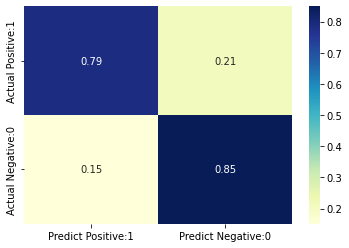

In [ ]:
# import SVC classifier
from sklearn.svm import LinearSVC

# instantiate classifier with default hyperparameters
svc=LinearSVC(class_weight="balanced", max_iter=1800) 
svc.fit(X,y)
# make predictions on test set
start = time.perf_counter()
y_pred = cross_val_predict(svc, X, y, cv=k)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

# print confusion matrix
my_cm_dec(y, y_pred)
plt.show()


In [ ]:
# print performance scores
start = time.perf_counter()
my_scores(svc,X,y)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

accuracy: 0.8110931827349738
precision: 0.8910914700008454
auc: 0.8940246142420017
recall: 0.788654221413312
f1: 0.8248647452465351
TIME: 0.22909405720000298 min


## Random Forest Classifier

TIME: 0.2412296965166661 min


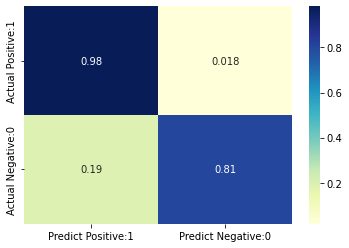

array([ 7449,  1777,   282, 15282])

In [ ]:
# import RF classifier
from sklearn.ensemble import RandomForestClassifier

# instantiate classifier with default hyperparameters
rfc=RandomForestClassifier() 
rfc.fit(X,y)
# make predictions on test set
start = time.perf_counter()
y_pred = cross_val_predict(rfc, X, y, cv=k)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

# print confusion matrix
# my_cm(y, y_pred)
# plt.show()
my_cm_dec(y, y_pred)


In [ ]:
# print performance scores
start = time.perf_counter()
my_scores(rfc,X,y)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

accuracy: 0.91847519160952
precision: 0.8985428404612386
auc: 0.9758292422649859
recall: 0.9814280977772126
f1: 0.9380757165262666
TIME: 0.3075698922999891 min


Random Forest Permutation Feature Importance 

## XGBoost Classifier

TIME: 0.41693509233332404 min


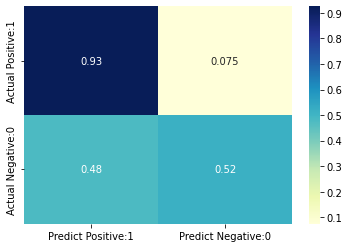

array([ 4783,  4443,  1164, 14400])

In [ ]:
#XGBoost Classifier
from xgboost import plot_importance, XGBClassifier # or XGBRegressor

# instantiate classifier with default hyperparameters
gbc=XGBClassifier()

# make predictions on test set
start = time.perf_counter()
y_pred = cross_val_predict(gbc, X, y, cv=k)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

# print confusion matrix
my_cm_dec(y, y_pred)


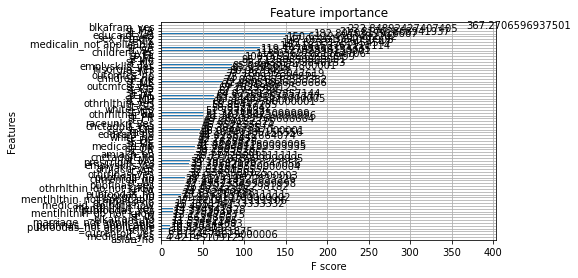

In [ ]:
gbc.fit(X,  y)
plot_importance(gbc, importance_type='gain')
plt.show()
gbc_feat_imp = gbc.get_booster().get_score(importance_type = 'gain')

In [ ]:
print("GBC Feature Importance")
print(gbc_feat_imp)

GBC Feature Importance
{'blkafram_yes': 367.2706596937501, 'st_CA': 213.81702868941937, 'st_MA': 222.84892427407405, 'sex_female': 150.61224703482762, 'othrhlthin_no': 51.32713025099999, 'educaid_yes': 182.8070319916667, 'st_GA': 142.18153761111114, 'st_TX': 147.06161084090908, 'emplysklls_no': 33.785821702647056, 'amiakn_no': 39.668353065, 'medicaid_yes': 5.6164574625000006, 'outcmfcs_no': 77.1861923047619, 'currenroll_yes': 6.079315661875, 'medicalin_not applicable': 143.82331383454547, 'st_MD': 63.39259167777777, 'medicaid_no': 41.926334180000005, 'children_no': 75.750917636875, 'prescripin_yes': 34.18245698, 'st_FL': 113.03627021764706, 'hisorgin_yes': 83.9394916, 'white_no': 44.0286812664074, 'children_yes': 118.72782896150001, 'st_SC': 119.14708959333335, 'raceunkn_yes': 49.004152325, 'st_MI': 100.00219369999999, 'hisorgin_no': 23.13631372111111, 'st_OK': 74.00676533333332, 'pubfinas_no': 29.957216475000003, 'othrfinas_no': 17.580045471111106, 'othrhlthin_do not know': 26.6702208

In [ ]:
# print performance scores
start = time.perf_counter()
my_scores(gbc,X,y)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

accuracy: 0.7738200887454619
precision: 0.7642040842453488
auc: 0.83503105913243
recall: 0.9252082856781867
f1: 0.8369977051471734
TIME: 0.41211557281665895 min


## Logistic Regression

TIME: 0.042711311299990486 min
[    0  9226     0 15564]
(tn, fp, fn, tp)


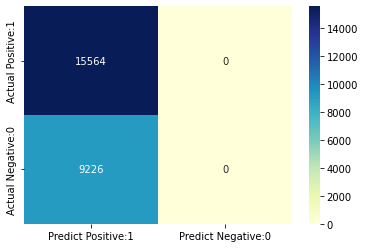

In [ ]:
# import log classifier
from sklearn.linear_model import LogisticRegressionCV

# instantiate classifier with default hyperparameters
lrc=LogisticRegressionCV(Cs=1) 
lrc.fit(X,y)
# make predictions on test set
start = time.perf_counter()
y_pred = cross_val_predict(lrc, X, y, cv=k)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

# print confusion matrix
my_cm(y, y_pred)

In [ ]:
# print performance scores
start = time.perf_counter()
my_scores(lrc,X,y)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

accuracy: 0.627833803953207
precision: 0.627833803953207
auc: 0.7082043702741231
recall: 1.0
f1: 0.7713733428707459
TIME: 0.045855533150006525 min


Logistic Regression Classifier Permutation Feature Importance

# Permutation Feature Importance #


In [ ]:
X.head()

,st_AK,st_AL,st_AR,st_AZ,st_CA,st_CO,st_CT,st_DC,st_DE,st_FL,...,medicalin_not applicable,mentlhlthin_no,mentlhlthin_yes,mentlhlthin_do not know,mentlhlthin_not applicable,prescripin_no,prescripin_yes,prescripin_do not know,prescripin_not applicable,baseline_yes
0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,1
1,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,1
2,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,1
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,1


In [ ]:
from sklearn.inspection import permutation_importance # 1002
def get_imp(model, imp_by_feat):
  r = permutation_importance(model, X.iloc[test_index, :], y.iloc[test_index],
                              n_repeats=30,     # can change this
                              random_state=0)

  for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
      feat = X.columns[i]
      imp = r.importances_mean[i]
      if feat in imp_by_feat:
        imp_by_feat[feat] += imp
      else:
        imp_by_feat[feat] = imp
        
      print(f"{feat:<8}\t"
            f"{imp:.3f}\t"
            f" +/- {r.importances_std[i]:.3f}")
  return imp_by_feat
      


In [ ]:


# Random forest, gradient boosting, logistic regression, linear svc
# rfc, xgb, lrc, svc

splits = kfold.split(X, y)

rfc_imp_by_feat = {}
gbc_imp_by_feat = {}
lrc_imp_by_feat = {}
svc_imp_by_feat = {}

for n,(train_index, test_index) in enumerate(splits):   # each of k training/test sets
  # RFC
  print("RFC permutation importance...")
  get_imp(rfc, rfc_imp_by_feat)
      

  # GBC
  print("GBC permutation importance...")
  get_imp(gbc, gbc_imp_by_feat)

        
  # LRC
  print("LRC permutation importance...")
  get_imp(lrc, lrc_imp_by_feat)

  # SVC
  print("SVC permutation importance...")
  get_imp(svc, svc_imp_by_feat)
  


RFC permutation importance...
st_CA   	0.076	 +/- 0.002
sex_female	0.065	 +/- 0.002
blkafram_yes	0.041	 +/- 0.002
st_TX   	0.036	 +/- 0.001
st_MA   	0.036	 +/- 0.001
emplysklls_no	0.029	 +/- 0.001
othrhlthin_no	0.027	 +/- 0.002
st_GA   	0.022	 +/- 0.001
hisorgin_yes	0.020	 +/- 0.001
st_NY   	0.018	 +/- 0.001
white_no	0.016	 +/- 0.001
st_FL   	0.015	 +/- 0.001
educaid_yes	0.015	 +/- 0.001
othrfinas_yes	0.014	 +/- 0.001
sex_male	0.013	 +/- 0.001
st_SC   	0.012	 +/- 0.001
othrhlthin_do not know	0.011	 +/- 0.001
hisorgin_no	0.010	 +/- 0.001
st_MI   	0.010	 +/- 0.000
white_yes	0.009	 +/- 0.001
medicaid_yes	0.009	 +/- 0.001
emplysklls_yes	0.009	 +/- 0.001
medicaid_no	0.009	 +/- 0.000
blkafram_no	0.008	 +/- 0.001
outcmfcs_no	0.008	 +/- 0.001
currenroll_no	0.008	 +/- 0.001
st_MD   	0.008	 +/- 0.000
st_OK   	0.007	 +/- 0.000
medicaid_do not know	0.006	 +/- 0.000
st_IA   	0.005	 +/- 0.000
st_KS   	0.005	 +/- 0.000
cnctadult_no	0.005	 +/- 0.000
st_IN   	0.005	 +/- 0.001
currenroll_yes	0.005	 +/- 

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
# allvals = list(rfc_imp_by_feat.values()) \
#         .append(list(gbc_imp_by_feat.values())) \
#         .append(list(lrc_imp_by_feat.values())) \
#         .append(list(svc_imp_by_feat.values()))
# max_val = np.amax(allvals)
n = 10

rfcvals = [(k,v) for k, v in rfc_imp_by_feat.items()]
print("rfcvals:\t", rfcvals)
rfcvals.sort(reverse = True, key = lambda t: t[1])
rfcvals = [pair for pair in rfcvals if pair[0][:3] != 'st_']
rfcvals = rfcvals[:10]

gbcvals = [(k,v) for k, v in gbc_imp_by_feat.items()]
gbcvals.sort(reverse = True, key = lambda t: t[1])
gbcvals = [pair for pair in gbcvals if pair[0][:3] != 'st_']
gbcvals = gbcvals[:10]

lrcvals = [(k,v) for k, v in lrc_imp_by_feat.items()]
lrcvals.sort(reverse = True, key = lambda t: t[1])
lrcvals = [pair for pair in lrcvals if pair[0][:3] != 'st_']
lrcvals = lrcvals[:10]

svcvals = [(k,v) for k, v in svc_imp_by_feat.items()]
svcvals.sort(reverse = True, key = lambda t: t[1])
svcvals = [pair for pair in svcvals if pair[0][:3] != 'st_']
svcvals = svcvals[:10]


fig = go.Figure(layout_title_text="Feature Importance")
fig.add_trace(go.Scatterpolar(    # RFC
      # r=list(rfc_imp_by_feat.values()),
      r=[x[1] for x in rfcvals],
      theta=[x[0] for x in rfcvals],
      # fill='none',
      name='Random Forest',
      # connectgaps=True
))
fig.add_trace(go.Scatterpolar(      # GBC
      r=[x[1] for x in gbcvals],
      theta=[x[0] for x in gbcvals],
      # fill='toself',
      name='XGBoost',
      # connectgaps=True
))
fig.add_trace(go.Scatterpolar(      # LRC
      r=[x[1] for x in lrcvals],
      theta=[x[0] for x in lrcvals],
      # fill='toself',
      name='Logistic Regression',
      # connectgaps=True
))

# fig.add_trace(go.Scatterpolar(      # SVC
#       r=[x[1] for x in svcvals],
#       theta=[x[0] for x in svcvals],
#       fill='tonext',
#       name='SVM'
# ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, .37]
    )),
  showlegend=True
)

fig.show()


rfcvals:	 [('st_CA', 0.38974720989646366), ('sex_female', 0.3367419658464435), ('blkafram_yes', 0.208928331316391), ('st_TX', 0.18298372999865536), ('st_MA', 0.17600510958719917), ('emplysklls_no', 0.14627537985746944), ('othrhlthin_no', 0.1254739814441307), ('st_GA', 0.10133790506924831), ('hisorgin_yes', 0.08407287884899826), ('st_NY', 0.07220653489310205), ('white_no', 0.07754470888799245), ('st_FL', 0.06518085249428532), ('educaid_yes', 0.0790439693424768), ('othrfinas_yes', 0.06448836896598091), ('sex_male', 0.07326206803818741), ('st_SC', 0.0716686836089821), ('othrhlthin_do not know', 0.04886378916229666), ('hisorgin_no', 0.05423557886244456), ('st_MI', 0.050981578593518914), ('white_yes', 0.046893908834207396), ('medicaid_yes', 0.054948231813903445), ('emplysklls_yes', 0.04771413204249026), ('medicaid_no', 0.03671507328223744), ('blkafram_no', 0.043686970552642215), ('outcmfcs_no', 0.03489982519833261), ('currenroll_no', 0.04059432566895254), ('st_MD', 0.035666263278203575), ('

In [ ]:
! pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 114 kB/s 


In [ ]:
fig.write_image('../img/radar1.jpeg', engine="kaleido")


ValueError: ignored

# Stratified Sampling #

In [ ]:
from xgboost import XGBClassifier

# instantiate classifier with default hyperparameters
model=XGBClassifier(class_weight="balanced")
#cm=[0,0,0,0]
auc=[]
f1=[]
y_truth=[]
y_pred=[]
splits = kfold.split(X, y)
for n,(train_index, test_index) in enumerate(splits):
  model.fit(X.iloc[train_index, :-1], y.iloc[train_index])
  pred = model.predict(X.iloc[test_index, :-1])
  f=f1_score(y.iloc[test_index], pred)
  f1.append(f)
  a=roc_auc_score(y.iloc[test_index], pred)
  auc.append(a)
  print("FOLD {} \n AUC {}".format(n,a))
  # yi = my_cm_dec(y.iloc[test_index,], pred)
  # print(yi)
  # cm= [cm[i]+ yi[i] for i in range(len(cm))]
  for i in y[test_index]: y_truth.append(i)
  for i in pred: y_pred.append(i)
print(sum(auc)/5)
print(stdev(auc))
print(sum(f1)/5)
print(stdev(f1))
print(my_cm_dec(y_truth,y_pred))

print("Female by Percenct")
print(my_cm_dec(pd.Series(y_truth).iloc[X.index[X['sex_female'] == True].values], pd.Series(y_pred).iloc[X.index[X['sex_female'] == True].values]))
plt.show()
print("Male by Percenct")
print(my_cm_dec(pd.Series(y_truth).iloc[X.index[X['sex_male'] == True].values], pd.Series(y_pred).iloc[X.index[X['sex_male'] == True].values]))
plt.show()

for i in ['South', 'Midwest', "Northeast", 'West']:
  print("Breakdown by {}".format(i))
  print(my_cm_dec(pd.Series(y_truth)[region.index[region == i]], pd.Series(y_pred)[region.index[region == i]]))
  plt.show()


for i in ['amiakn','asian', 'blkafram', 'hawaiipi', 'white','raceunkn', 'hisorgin']:
  print("Breakdown by {}".format(i))

  print("YES - By percent")
  print(my_cm_dec(pd.Series(y_truth).iloc[X.index[X[i+'_yes'] == True].values], pd.Series(y_pred).iloc[X.index[X[i+'_yes'] == True].values]))
  plt.show()

  print("NO - by percent")
  print(my_cm_dec(pd.Series(y_truth).iloc[X.index[X[i+'_no'] == True].values], pd.Series(y_pred).iloc[X.index[X[i+'_no'] == True].values]))
  plt.show()

In [ ]:
# Linear SVC
from sklearn.svm import LinearSVC

model=LinearSVC(class_weight="balanced", max_iter=1800) 
auc=[]
f1=[]
y_truth=[]
y_pred=[]
splits = kfold.split(X, y)
for n,(train_index, test_index) in enumerate(splits):
  model.fit(X.iloc[train_index, :-1], y.iloc[train_index])
  pred = model.predict(X.iloc[test_index, :-1])
  f=f1_score(y.iloc[test_index], pred)
  f1.append(f)
  a=roc_auc_score(y.iloc[test_index], pred)
  auc.append(a)
  print("FOLD {} \n AUC {}".format(n,a))
  # yi = my_cm_dec(y.iloc[test_index,], pred)
  # print(yi)
  # cm= [cm[i]+ yi[i] for i in range(len(cm))]
  for i in y[test_index]: y_truth.append(i)
  for i in pred: y_pred.append(i)
print(sum(auc)/5)
print(stdev(auc))
print(sum(f1)/5)
print(stdev(f1))
print(my_cm_dec(y_truth,y_pred))

print("Female by Percenct")
print(my_cm_dec(pd.Series(y_truth).iloc[X.index[X['sex_female'] == True].values], pd.Series(y_pred).iloc[X.index[X['sex_female'] == True].values]))
plt.show()
print("Male by Percenct")
print(my_cm_dec(pd.Series(y_truth).iloc[X.index[X['sex_male'] == True].values], pd.Series(y_pred).iloc[X.index[X['sex_male'] == True].values]))
plt.show()

for i in ['South', 'Midwest', "Northeast", 'West']:
  print("Breakdown by {}".format(i))
  print(my_cm_dec(pd.Series(y_truth)[region.index[region == i]], pd.Series(y_pred)[region.index[region == i]]))
  plt.show()


for i in ['amiakn','asian', 'blkafram', 'hawaiipi', 'white','raceunkn', 'hisorgin']:
  print("Breakdown by {}".format(i))

  print("YES - By percent")
  print(my_cm_dec(pd.Series(y_truth).iloc[X.index[X[i+'_yes'] == True].values], pd.Series(y_pred).iloc[X.index[X[i+'_yes'] == True].values]))
  plt.show()

  print("NO - by percent")
  print(my_cm_dec(pd.Series(y_truth).iloc[X.index[X[i+'_no'] == True].values], pd.Series(y_pred).iloc[X.index[X[i+'_no'] == True].values]))
  plt.show()

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegressionCV

model=LogisticRegressionCV(Cs=1, class_weight="balanced") 
auc=[]
f1=[]
y_truth=[]
y_pred=[]
splits = kfold.split(X, y)
for n,(train_index, test_index) in enumerate(splits):
  model.fit(X.iloc[train_index, :-1], y.iloc[train_index])
  pred = model.predict(X.iloc[test_index, :-1])
  f=f1_score(y.iloc[test_index], pred)
  f1.append(f)
  a=roc_auc_score(y.iloc[test_index], pred)
  auc.append(a)
  print("FOLD {} \n AUC {}".format(n,a))
  # yi = my_cm_dec(y.iloc[test_index,], pred)
  # print(yi)
  # cm= [cm[i]+ yi[i] for i in range(len(cm))]
  for i in y[test_index]: y_truth.append(i)
  for i in pred: y_pred.append(i)
print(sum(auc)/5)
print(stdev(auc))
print(sum(f1)/5)
print(stdev(f1))
print(my_cm_dec(y_truth,y_pred))

print("Female by Percenct")
print(my_cm_dec(pd.Series(y_truth).iloc[X.index[X['sex_female'] == True].values], pd.Series(y_pred).iloc[X.index[X['sex_female'] == True].values]))
plt.show()
print("Male by Percenct")
print(my_cm_dec(pd.Series(y_truth).iloc[X.index[X['sex_male'] == True].values], pd.Series(y_pred).iloc[X.index[X['sex_male'] == True].values]))
plt.show()

for i in ['South', 'Midwest', "Northeast", 'West']:
  print("Breakdown by {}".format(i))
  print(my_cm_dec(pd.Series(y_truth)[region.index[region == i]], pd.Series(y_pred)[region.index[region == i]]))
  plt.show()


for i in ['amiakn','asian', 'blkafram', 'hawaiipi', 'white','raceunkn', 'hisorgin']:
  print("Breakdown by {}".format(i))

  print("YES - By percent")
  print(my_cm_dec(pd.Series(y_truth).iloc[X.index[X[i+'_yes'] == True].values], pd.Series(y_pred).iloc[X.index[X[i+'_yes'] == True].values]))
  plt.show()

  print("NO - by percent")
  print(my_cm_dec(pd.Series(y_truth).iloc[X.index[X[i+'_no'] == True].values], pd.Series(y_pred).iloc[X.index[X[i+'_no'] == True].values]))
  plt.show()

In [ ]:
#random forest
from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier(n_estimators = 100) 
auc=[]
f1=[]
y_truth=[]
y_pred=[]
splits = kfold.split(X, y)
for n,(train_index, test_index) in enumerate(splits):
  model.fit(X.iloc[train_index, :-1], y.iloc[train_index])
  pred = model.predict(X.iloc[test_index, :-1])
  f=f1_score(y.iloc[test_index], pred)
  f1.append(f)
  a=roc_auc_score(y.iloc[test_index], pred)
  auc.append(a)
  print("FOLD {} \n AUC {}".format(n,a))
  # yi = my_cm_dec(y.iloc[test_index,], pred)
  # print(yi)
  # cm= [cm[i]+ yi[i] for i in range(len(cm))]
  for i in y[test_index]: y_truth.append(i)
  for i in pred: y_pred.append(i)
print(sum(auc)/5)
print(stdev(auc))
print(sum(f1)/5)
print(stdev(f1))
print(my_cm_dec(y_truth,y_pred))

print("Female by Percenct")
print(my_cm_dec(pd.Series(y_truth).iloc[X.index[X['sex_female'] == True].values], pd.Series(y_pred).iloc[X.index[X['sex_female'] == True].values]))
plt.show()
print("Male by Percenct")
print(my_cm_dec(pd.Series(y_truth).iloc[X.index[X['sex_male'] == True].values], pd.Series(y_pred).iloc[X.index[X['sex_male'] == True].values]))
plt.show()

for i in ['South', 'Midwest', "Northeast", 'West']:
  print("Breakdown by {}".format(i))
  print(my_cm_dec(pd.Series(y_truth)[region.index[region == i]], pd.Series(y_pred)[region.index[region == i]]))
  plt.show()


for i in ['amiakn','asian', 'blkafram', 'hawaiipi', 'white','raceunkn', 'hisorgin']:
  print("Breakdown by {}".format(i))

  print("YES - By percent")
  print(my_cm_dec(pd.Series(y_truth).iloc[X.index[X[i+'_yes'] == True].values], pd.Series(y_pred).iloc[X.index[X[i+'_yes'] == True].values]))
  plt.show()

  print("NO - by percent")
  print(my_cm_dec(pd.Series(y_truth).iloc[X.index[X[i+'_no'] == True].values], pd.Series(y_pred).iloc[X.index[X[i+'_no'] == True].values]))
  plt.show()

#Over Sampling - Archive

In [ ]:
# OVER SAMPLING
over = pd.DataFrame()
for i in range(2):
  over=over.append(data[data["subabuse_yes"] == 1])
over=over.append(data[data["subabuse_yes"] == 1].iloc[:int(5980 /2),:])
data=data.append(over).sample(frac=1)


In [ ]:
k=5
y = data.loc[:,target]
X = data.loc[:,data.columns != target]
X=X.reset_index(drop=True)

In [ ]:
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)
#data['target'] IS THE VARIABLE USED FOR STRATIFIED SAMPLING.
splits = kfold.split(data.iloc[:,:-1],data[target])
print(f'PROPORTION OF TARGET IN THE ORIGINAL DATA\n{data[target].value_counts() / len(data)}\n\n')
for n,(train_index,test_index) in enumerate(splits):
    print(f'SPLIT NO {n+1}\nTRAINING SET SIZE: {np.round(len(train_index) / (len(train_index)+len(test_index)),2)}'+
          f'\tTEST SET SIZE: {np.round(len(test_index) / (len(train_index)+len(test_index)),2)}\nPROPORTION OF TARGET IN THE TRAINING SET\n'+
          f'{data.iloc[test_index,-1].value_counts() / len(data.iloc[test_index,-1])}\nPROPORTION OF TARGET IN THE TEST SET\n'+
          f'{data.iloc[train_index,-1].value_counts() / len(data.iloc[train_index,-1])}\n\n')

# SVC - Archive

In [ ]:
# import SVC classifier
from sklearn.svm import LinearSVC

# instantiate classifier with default hyperparameters
svc=LinearSVC(class_weight="balanced", max_iter=1800) 

# make predictions on test set
start = time.perf_counter()
y_pred = cross_val_predict(svc, X, y, cv=k)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

# print confusion matrix
print(my_cm_dec(y, y_pred))
plt.show()


In [ ]:
# print performance scores
start = time.perf_counter()
my_scores(svc,X,y)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

## Random Forest Classifier

In [ ]:
# import RF classifier
from sklearn.ensemble import RandomForestClassifier

# instantiate classifier with default hyperparameters
rfc=RandomForestClassifier(class_weight="balanced") 

# make predictions on test set
start = time.perf_counter()
y_pred = cross_val_predict(rfc, X, y, cv=k)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

# print confusion matrix
# my_cm(y, y_pred)
# plt.show()
print(my_cm_dec(y, y_pred))


In [ ]:
# print performance scores
start = time.perf_counter()
my_scores(rfc,X,y)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

## XGBoost Classifier

In [ ]:
#XGBoost Classifier
from xgboost import XGBClassifier

# instantiate classifier with default hyperparameters
gbc=XGBClassifier(class_weight="balanced")

# make predictions on test set
start = time.perf_counter()
y_pred = cross_val_predict(gbc, X, y, cv=k)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

# print confusion matrix
print(my_cm_dec(y, y_pred))


In [ ]:
# print performance scores
start = time.perf_counter()
my_scores(gbc,X,y)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

## Logistic Regression

In [ ]:
# import log classifier
from sklearn.linear_model import LogisticRegressionCV

# instantiate classifier with default hyperparameters
lrc=LogisticRegressionCV(Cs=1, class_weight="balanced") 

# make predictions on test set
start = time.perf_counter()
y_pred = cross_val_predict(lrc, X, y, cv=k)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

# print confusion matrix
my_cm(y, y_pred)

In [ ]:
# print performance scores
start = time.perf_counter()
my_scores(lrc,X,y)
end = time.perf_counter()
print("TIME:",(end-start)/60,"min")

#With Oversampling + Stratified - Archive



In [ ]:
from xgboost import XGBClassifier

# instantiate classifier with default hyperparameters
model=XGBClassifier(class_weight="balanced")
cm=[0,0,0,0]
auc=[]
f1=[]
y=[]
y_pred=[]
splits = kfold.split(data.iloc[:,:-1],data[target])
for n,(train_index, test_index) in enumerate(splits):
  model.fit(data.iloc[train_index, :-1], data.iloc[train_index, -1])
  pred = model.predict(data.iloc[test_index, :-1])
  f=f1_score(data.iloc[test_index, -1], pred)
  f1.append(f)
  a=roc_auc_score(data.iloc[test_index, -1], pred)
  auc.append(a)
  for i in data.iloc[test_index, -1]: y.append(i)
  for i in pred: y_pred.append(i)
  cm= [cm[i]+ y[i] for i in range(len(cm))]
print(sum(auc)/5)
print(stdev(auc))
print(sum(f1)/5)
print(stdev(f1))
print(cm)


print("Female by Percenct")

print(my_cm_dec(pd.Series(y)[X.index[X['sex_female'] == True].tolist()],pd.Series(y_pred)[X.index[X['sex_female'] == True].tolist()]))
plt.show()
print("Male by Percenct")
print(my_cm_dec(pd.Series(y)[X.index[X['sex_male'] == True].tolist()],pd.Series(y_pred)[X.index[X['sex_male'] == True].tolist()]))
plt.show()

for i in ['white', 'blkafram']:
  print("Breakdown by {}".format(i))

  print("YES - By percent")
  print(my_cm_dec(pd.Series(y)[X.index[X[i+'_yes']==True].tolist()],pd.Series(y_pred)[X.index[X[i+'_yes'] == True].tolist()]))
  plt.show()

  print("NO - by percent")
  print(my_cm_dec(pd.Series(y)[X.index[X[i+'_no'] == True].tolist()],pd.Series(y_pred)[X.index[X[i+'_no'] == True].tolist()]))
  plt.show()

In [ ]:
# Linear SVC
from sklearn.svm import LinearSVC

model=LinearSVC(class_weight="balanced", max_iter=1800) 
cm=[0,0,0,0]
auc=[]
f1=[]
y=[]
y_pred=[]
splits = kfold.split(data.iloc[:,:-1],data[target])
for n,(train_index, test_index) in enumerate(splits):
  model.fit(data.iloc[train_index, :-1], data.iloc[train_index, -1])
  pred = model.predict(data.iloc[test_index, :-1])
  f=f1_score(data.iloc[test_index, -1], pred)
  f1.append(f)
  a=roc_auc_score(data.iloc[test_index, -1], pred)
  auc.append(a)
  for i in data.iloc[test_index, -1]: y.append(i)
  for i in pred: y_pred.append(i)
  cm= [cm[i]+ y[i] for i in range(len(cm))]
print(sum(auc)/5)
print(stdev(auc))
print(sum(f1)/5)
print(stdev(f1))
print(cm)


print("Female by Percenct")

print(my_cm_dec(pd.Series(y)[X.index[X['sex_female'] == True].tolist()],pd.Series(y_pred)[X.index[X['sex_female'] == True].tolist()]))
plt.show()
print("Male by Percenct")
print(my_cm_dec(pd.Series(y)[X.index[X['sex_male'] == True].tolist()],pd.Series(y_pred)[X.index[X['sex_male'] == True].tolist()]))
plt.show()

for i in ['white', 'blkafram']:
  print("Breakdown by {}".format(i))

  print("YES - By percent")
  print(my_cm_dec(pd.Series(y)[X.index[X[i+'_yes']==True].tolist()],pd.Series(y_pred)[X.index[X[i+'_yes'] == True].tolist()]))
  plt.show()

  print("NO - by percent")
  print(my_cm_dec(pd.Series(y)[X.index[X[i+'_no'] == True].tolist()],pd.Series(y_pred)[X.index[X[i+'_no'] == True].tolist()]))
  plt.show()

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegressionCV

model=LogisticRegressionCV(Cs=1, class_weight="balanced") 
cm=[0,0,0,0]
auc=[]
f1=[]
y=[]
y_pred=[]
splits = kfold.split(data.iloc[:,:-1],data[target])
for n,(train_index, test_index) in enumerate(splits):
  model.fit(data.iloc[train_index, :-1], data.iloc[train_index, -1])
  pred = model.predict(data.iloc[test_index, :-1])
  f=f1_score(data.iloc[test_index, -1], pred)
  f1.append(f)
  a=roc_auc_score(data.iloc[test_index, -1], pred)
  auc.append(a)
  for i in data.iloc[test_index, -1]: y.append(i)
  for i in pred: y_pred.append(i)
  cm= [cm[i]+ y[i] for i in range(len(cm))]
print(sum(auc)/5)
print(stdev(auc))
print(sum(f1)/5)
print(stdev(f1))
print(cm)


print("Female by Percenct")

print(my_cm_dec(pd.Series(y)[X.index[X['sex_female'] == True].tolist()],pd.Series(y_pred)[X.index[X['sex_female'] == True].tolist()]))
plt.show()
print("Male by Percenct")
print(my_cm_dec(pd.Series(y)[X.index[X['sex_male'] == True].tolist()],pd.Series(y_pred)[X.index[X['sex_male'] == True].tolist()]))
plt.show()

for i in ['white', 'blkafram']:
  print("Breakdown by {}".format(i))

  print("YES - By percent")
  print(my_cm_dec(pd.Series(y)[X.index[X[i+'_yes']==True].tolist()],pd.Series(y_pred)[X.index[X[i+'_yes'] == True].tolist()]))
  plt.show()

  print("NO - by percent")
  print(my_cm_dec(pd.Series(y)[X.index[X[i+'_no'] == True].tolist()],pd.Series(y_pred)[X.index[X[i+'_no'] == True].tolist()]))
  plt.show()

In [ ]:
#random forest
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(n_estimators = 10, criterion="entropy", class_weight="balanced") 
cm=[0,0,0,0]
auc=[]
f1=[]
y=[]
y_pred=[]
splits = kfold.split(data.iloc[:,:-1],data[target])
for n,(train_index, test_index) in enumerate(splits):
  model.fit(data.iloc[train_index, :-1], data.iloc[train_index, -1])
  pred = model.predict(data.iloc[test_index, :-1])
  f=f1_score(data.iloc[test_index, -1], pred)
  f1.append(f)
  a=roc_auc_score(data.iloc[test_index, -1], pred)
  auc.append(a)
  for i in data.iloc[test_index, -1]: y.append(i)
  for i in pred: y_pred.append(i)
print(sum(auc)/5)
print(stdev(auc))
print(sum(f1)/5)
print(stdev(f1))


print("Female by Percenct")

print(my_cm_dec(pd.Series(y)[X.index[X['sex_female'] == True].tolist()],pd.Series(y_pred)[X.index[X['sex_female'] == True].tolist()]))
plt.show()
print("Male by Percenct")
print(my_cm_dec(pd.Series(y)[X.index[X['sex_male'] == True].tolist()],pd.Series(y_pred)[X.index[X['sex_male'] == True].tolist()]))
plt.show()

for i in ['white', 'blkafram']:
  print("Breakdown by {}".format(i))

  print("YES - By percent")
  print(my_cm_dec(pd.Series(y)[X.index[X[i+'_yes']==True].tolist()],pd.Series(y_pred)[X.index[X[i+'_yes'] == True].tolist()]))
  plt.show()

  print("NO - by percent")
  print(my_cm_dec(pd.Series(y)[X.index[X[i+'_no'] == True].tolist()],pd.Series(y_pred)[X.index[X[i+'_no'] == True].tolist()]))
  plt.show()

In [ ]:
print("Breakdown by Sex")
print("Female by Number")
my_cm(y.iloc[X.index[X['sex_female'] == True].tolist()].values,y_pred[X.index[X['sex_female'] == True].tolist()])
plt.show()
print("Male by Number")
my_cm(y.iloc[X.index[X['sex_male'] == True].tolist()].values,y_pred[X.index[X['sex_male'] == True].tolist()])
plt.show()
print("Female by Percenct")
my_cm_dec(y.iloc[X.index[X['sex_female'] == True].tolist()].values,y_pred[X.index[X['sex_female'] == True].tolist()])
plt.show()
print("Male by Percenct")
my_cm_dec(y.iloc[X.index[X['sex_male'] == True].tolist()].values,y_pred[X.index[X['sex_male'] == True].tolist()])
plt.show()

for i in ['amiakn','asian', 'blkafram', 'hawaiipi', 'white','raceunkn', 'hisorgin']:
  print("Breakdown by {}".format(i))

  print("YES - By percent")
  my_cm_dec(y.iloc[X.index[X[i+'_yes']==True].tolist()].values,y_pred[X.index[X[i+'_yes'] == True].tolist()])
  plt.show()

  print("NO - by percent")
  my_cm_dec(y.iloc[X.index[X[i+'_no'] == True].tolist()].values,y_pred[X.index[X[i+'_no'] == True].tolist()])
  plt.show()

  print("YES - By numbers")
  my_cm(y.iloc[X.index[X[i+'_yes']==True].tolist()].values,y_pred[X.index[X[i+'_yes'] == True].tolist()])
  plt.show()

  print("NO - By numbers")
  my_cm(y.iloc[X.index[X[i+'_no'] == True].tolist()].values,y_pred[X.index[X[i+'_no'] == True].tolist()])
  plt.show()